<a href="https://colab.research.google.com/github/Marcellinus08/Deep-Learning/blob/main/IMDB_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Library

In [3]:
# === Library ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

import tensorflow as tf

Parameter

In [12]:
num_words = 30000      # Hanya gunakan 30.000 kata paling sering muncul
maxlen = 500           # Setiap review akan dipotong/padding ke panjang 500
embedding_dim = 128
lstm_units = 64
dropout_rate = 0.5
batch_size = 256
epochs = 10

Load Dataset dan Preprocessing

In [13]:
# === Load Dataset IMDB ===
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)

# === Preprocessing: Padding ===
x_train = pad_sequences(x_train, maxlen=maxlen, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=maxlen, padding='post', truncating='post')

Bangun Model BiRNN

In [14]:
model = Sequential([
    Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=maxlen),
    Bidirectional(LSTM(lstm_units, return_sequences=False)),
    Dropout(dropout_rate),
    Dense(64, activation='relu'),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Kompilasi dan Early Stopping

In [15]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Training

In [16]:
history = model.fit(
    x_train, y_train,
    validation_split=0.2,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.5659 - loss: 0.6657 - val_accuracy: 0.8180 - val_loss: 0.4668
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.8741 - loss: 0.3339 - val_accuracy: 0.8776 - val_loss: 0.3140
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.9444 - loss: 0.1730 - val_accuracy: 0.8756 - val_loss: 0.5372
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.9448 - loss: 0.1851 - val_accuracy: 0.8684 - val_loss: 0.3830
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.9728 - loss: 0.0838 - val_accuracy: 0.8656 - val_loss: 0.4151


Evaluasi Model di Testing Set

In [17]:
# Prediksi probabilitas
y_pred_proba = model.predict(x_test)
# Konversi ke label (threshold = 0.5)
y_pred = (y_pred_proba >= 0.5).astype(int)


782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step


Hitung Metrik Evaluasi

In [18]:
# Evaluasi
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

# Tampilkan hasil
print(f"Akurasi  : {acc:.4f}")
print(f"Presisi  : {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")


Akurasi  : 0.8576
Presisi  : 0.8924
Recall   : 0.8131
F1 Score : 0.8509
AUC      : 0.9331


Visualisasi: Akurasi & Loss Selama Training

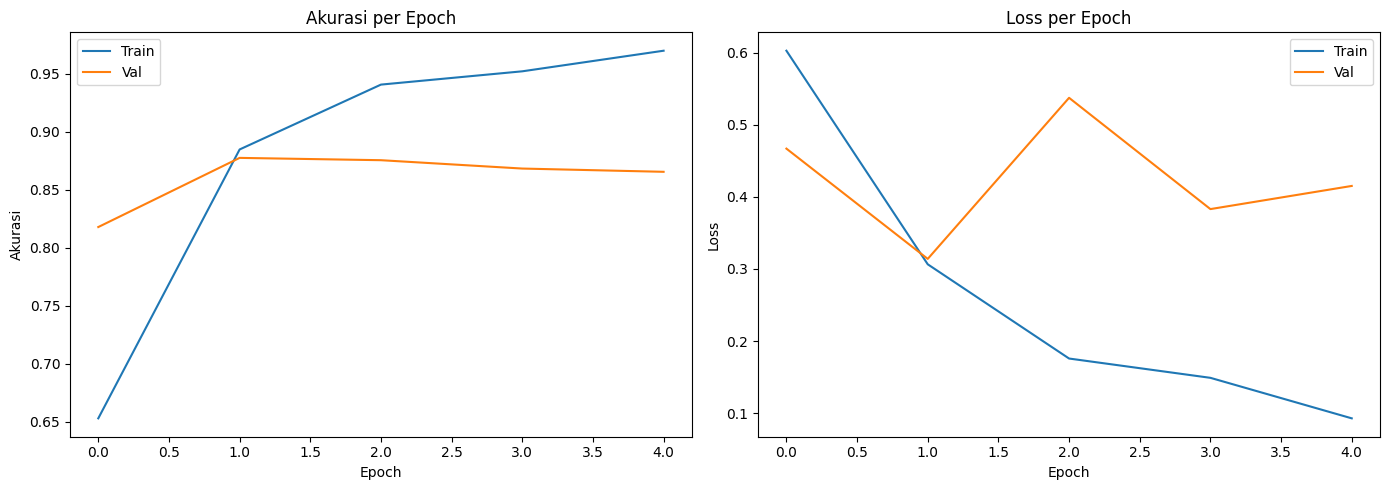

In [19]:
# Plot akurasi dan loss
plt.figure(figsize=(14, 5))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Akurasi per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Visualisasi: ROC Curve

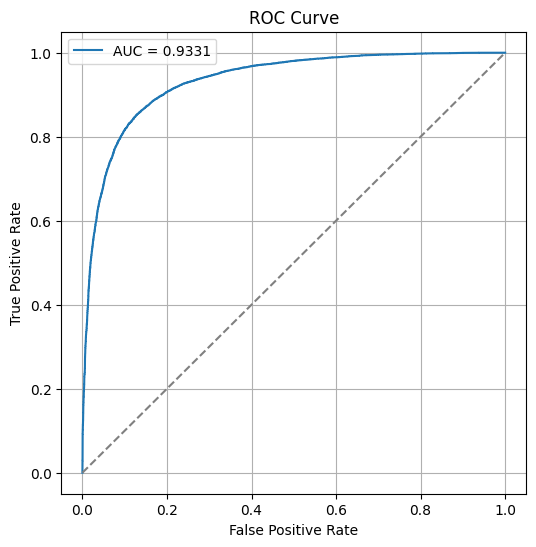

In [20]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()


Kombinasi hyperparameter

In [21]:
from tensorflow.keras.backend import clear_session

embedding_dims = [128, 256]
lstm_units_list = [64, 128]
dropout_rates = [0.3, 0.5]
batch_sizes = [64, 128]

best_accuracy = 0
best_config = {}

Grid Search Sederhana (manual loop)

In [22]:
for emb in embedding_dims:
    for lstm_units in lstm_units_list:
        for drop in dropout_rates:
            for batch in batch_sizes:
                print(f"Training model: Emb={emb}, LSTM={lstm_units}, Drop={drop}, Batch={batch}")

                clear_session()  # clear memory sebelum training baru
                model = Sequential([
                    Embedding(input_dim=num_words, output_dim=emb, input_length=maxlen),
                    Bidirectional(LSTM(lstm_units)),
                    Dropout(drop),
                    Dense(64, activation='relu'),
                    Dropout(drop),
                    Dense(1, activation='sigmoid')
                ])

                model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

                history = model.fit(
                    x_train, y_train,
                    validation_split=0.2,
                    epochs=10,
                    batch_size=batch,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
                    verbose=0  # Matikan log agar tidak terlalu panjang
                )

                val_acc = max(history.history['val_accuracy'])

                print(f"Validation Accuracy: {val_acc:.4f}")
                if val_acc > best_accuracy:
                    best_accuracy = val_acc
                    best_config = {
                        'embedding_dim': emb,
                        'lstm_units': lstm_units,
                        'dropout_rate': drop,
                        'batch_size': batch
                    }

Training model: Emb=128, LSTM=64, Drop=0.3, Batch=64


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Validation Accuracy: 0.8550
Training model: Emb=128, LSTM=64, Drop=0.3, Batch=128
Validation Accuracy: 0.8526
Training model: Emb=128, LSTM=64, Drop=0.5, Batch=64
Validation Accuracy: 0.8646
Training model: Emb=128, LSTM=64, Drop=0.5, Batch=128
Validation Accuracy: 0.8718
Training model: Emb=128, LSTM=128, Drop=0.3, Batch=64
Validation Accuracy: 0.8648
Training model: Emb=128, LSTM=128, Drop=0.3, Batch=128
Validation Accuracy: 0.8848
Training model: Emb=128, LSTM=128, Drop=0.5, Batch=64
Validation Accuracy: 0.8724
Training model: Emb=128, LSTM=128, Drop=0.5, Batch=128
Validation Accuracy: 0.8730
Training model: Emb=256, LSTM=64, Drop=0.3, Batch=64
Validation Accuracy: 0.8728
Training model: Emb=256, LSTM=64, Drop=0.3, Batch=128
Validation Accuracy: 0.8852
Training model: Emb=256, LSTM=64, Drop=0.5, Batch=64
Validation Accuracy: 0.8690
Training model: Emb=256, LSTM=64, Drop=0.5, Batch=128
Validation Accuracy: 0.8834
Training model: Emb=256, LSTM=128, Drop=0.3, Batch=64
Validation Accura

In [23]:
print("=== Best Configuration ===")
print(best_config)
print(f"Best Validation Accuracy: {best_accuracy:.4f}")

=== Best Configuration ===
{'embedding_dim': 256, 'lstm_units': 64, 'dropout_rate': 0.3, 'batch_size': 128}
Best Validation Accuracy: 0.8852
